In [4]:
"""
Authors:
Mihir Upasani (mu2047@nyu.edu)
Shivani Gawande
Fabiha Khalid
"""
import time

import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm


class Basics():

    def __init__(self, model, optimizer, schedule, criterion, training_dl, testing_dl, modelName):
        self.model = model
        self.optimizer = optimizer
        self.schedule = schedule
        self.criterion = criterion
        self.device = torch.device(
            'cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.trainingHistory = {
            'accuracy': [],
            'loss': [],
        }
        self.testingHistory = {
            'accuracy': [],
            'loss': [],
        }
        self.validationHistory = {
            'accuracy': [],
            'loss': [],
        }
        self.trainingDataLoader = training_dl
        self.testingDataLoader = testing_dl
        self.modelName = modelName

    def __calculateAccuracy(self, y_pred, y):
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
        return acc

    def __getTime(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def _countParameters(self):
        total_params = 0
        for name, parameter in self.model.named_parameters():
            params = parameter.numel()
            total_params += params
        return total_params

    def _trainModel(self, epoch):
        """
        Abstraction layer for training steps
        1. Make predictions
        2. Calculate loss, accuracy
        3. Propogate loss backwards and update weights
        4. Record statistics, i.e loss, accuracy and time per epoch
        """

        # To indicate model in training phase
        # Will also turn on dropout in case we use it
        self.model.train()

        epoch_loss = 0
        epoch_acc = 0

        with tqdm(self.trainingDataLoader) as tqdmObject:

            startTime = time.time()
            for (x, y) in tqdmObject:
                tqdmObject.set_description(desc=f"Epoch {epoch+1}")
                x = x.to(self.device)
                y = y.to(self.device)

                self.optimizer.zero_grad()

                # Step 1
                y_pred = self.model(x)

                # Step 2
                loss = self.criterion(y_pred, y)
                acc = self.__calculateAccuracy(y_pred, y)

                # Step 3
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()
                epoch_acc += acc.item()
                tqdmObject.set_postfix(accuracy=epoch_acc/len(self.trainingDataLoader),
                                       loss=epoch_loss/len(self.trainingDataLoader))
            # if self.schedule:
            #     self.schedule.step()
            endTime = time.time()

        trainingMinutes, trainingSeconds = self.__getTime(startTime, endTime)
        trainingSeconds += 60 * trainingMinutes
        return epoch_acc/len(self.trainingDataLoader), epoch_loss/len(self.trainingDataLoader), trainingSeconds

    def _evaluateModel(self):
        """
        Abstraction layer for validation steps
        1. Make predictions
        2. Calculate loss, accuracy
        3. Record statistics, i.e loss, accuracy and time per epoch
        """

        # To indicate model in training phase
        # Will also turn on dropout in case we use it
        self.model.eval()

        epoch_loss = 0
        epoch_acc = 0

        with torch.no_grad():
            for (x, y) in self.testingDataLoader:

                x = x.to(self.device)
                y = y.to(self.device)

                # Step 1
                y_pred = self.model(x)

                # Step 2
                loss = self.criterion(y_pred, y)
                acc = self.__calculateAccuracy(y_pred, y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_acc/len(self.testingDataLoader), epoch_loss/len(self.testingDataLoader)

    def trainEpochs(self, epochs=10, plot_results=True):
        """
        Will build more control into it, for now keeping it limited to 

        epochs: how many epochs to train for
        validate: do we even have a validation dataset
        plot_results: whether to plot training, testing and validation losses, accuracies 
        """

        for epoch in range(epochs):
            startTime = time.time()
            trainingAccuracy, trainingLoss, trainingSeconds = self._trainModel(
                epoch)
            testingAccuracy, testingLoss = self._evaluateModel()
            endTime = time.time()
            self.schedule.step(trainingAccuracy)
            epochMinutes, epochSeconds = self.__getTime(startTime, endTime)
            epochSeconds += epochMinutes*60
            print("TrainingLoss:%.2f|TrainingAccuracy:%.2f|EpochTime:%.2fs|TestingLoss:%.2f|TestingAccuracy:%.2f\n" % (
                trainingLoss, trainingAccuracy*100, epochSeconds, testingLoss, testingAccuracy*100))

            self.trainingHistory["loss"].append(trainingLoss)
            self.trainingHistory["accuracy"].append(trainingAccuracy)

            self.testingHistory["loss"].append(testingLoss)
            self.testingHistory["accuracy"].append(testingAccuracy)

        if plot_results:

            X = np.arange(1, epochs+1)

            plt.figure(1)
            plt.plot(X, self.trainingHistory['loss'], label='train_loss')
            plt.plot(X, self.testingHistory['loss'], label='test_loss')
            plt.legend()
            plt.savefig("./outputs/" + self.modelName + "LossVsEpochs.jpg")

            plt.figure(2)
            plt.plot(
                X, self.trainingHistory['accuracy'], label='train_acc')
            plt.plot(
                X, self.testingHistory['accuracy'], label='test_acc')
            plt.legend()
            plt.savefig("./outputs/" + self.modelName + "AccVsEpochs.jpg")

In [5]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear1 = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, kernel_size=3):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, kernel_size))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet18_mod():
    return ResNet(BasicBlock, [2, 1, 1, 1])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")  # PyTorch v0.4.0
    net = ResNet34().to(device)
    summary(net, (3, 28, 28))
    # y = net(torch.randn(1, 3, 32, 32))
    # print(y.size())

Files already downloaded and verified
Files already downloaded and verified
Model has 4977226 parameters
You have 22774 left!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 3

Epoch 1: 100%|██████████| 1563/1563 [06:11<00:00,  4.21it/s, accuracy=0.5, loss=1.37]


TrainingLoss:1.37|TrainingAccuracy:49.97|EpochTime:384.00s|TestingLoss:1.00|TestingAccuracy:64.38



Epoch 2: 100%|██████████| 1563/1563 [04:46<00:00,  5.46it/s, accuracy=0.673, loss=0.921]


TrainingLoss:0.92|TrainingAccuracy:67.29|EpochTime:299.00s|TestingLoss:0.95|TestingAccuracy:69.17



Epoch 3: 100%|██████████| 1563/1563 [04:44<00:00,  5.49it/s, accuracy=0.743, loss=0.733]


TrainingLoss:0.73|TrainingAccuracy:74.30|EpochTime:298.00s|TestingLoss:0.69|TestingAccuracy:77.38



Epoch 4: 100%|██████████| 1563/1563 [04:48<00:00,  5.42it/s, accuracy=0.785, loss=0.621]


TrainingLoss:0.62|TrainingAccuracy:78.50|EpochTime:302.00s|TestingLoss:0.56|TestingAccuracy:80.47



Epoch 5: 100%|██████████| 1563/1563 [04:38<00:00,  5.60it/s, accuracy=0.807, loss=0.557]


TrainingLoss:0.56|TrainingAccuracy:80.73|EpochTime:292.00s|TestingLoss:0.51|TestingAccuracy:82.89



Epoch 6: 100%|██████████| 1563/1563 [04:47<00:00,  5.43it/s, accuracy=0.827, loss=0.502]


TrainingLoss:0.50|TrainingAccuracy:82.71|EpochTime:300.00s|TestingLoss:0.55|TestingAccuracy:80.97



Epoch 7: 100%|██████████| 1563/1563 [04:27<00:00,  5.85it/s, accuracy=0.841, loss=0.462]


TrainingLoss:0.46|TrainingAccuracy:84.13|EpochTime:279.00s|TestingLoss:0.49|TestingAccuracy:82.71



Epoch 8: 100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s, accuracy=0.852, loss=0.429]


TrainingLoss:0.43|TrainingAccuracy:85.18|EpochTime:281.00s|TestingLoss:0.44|TestingAccuracy:84.85



Epoch 9: 100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s, accuracy=0.863, loss=0.403]


TrainingLoss:0.40|TrainingAccuracy:86.26|EpochTime:281.00s|TestingLoss:0.47|TestingAccuracy:83.75



Epoch 10: 100%|██████████| 1563/1563 [04:32<00:00,  5.73it/s, accuracy=0.87, loss=0.38]


TrainingLoss:0.38|TrainingAccuracy:86.99|EpochTime:285.00s|TestingLoss:0.47|TestingAccuracy:84.35



Epoch 11: 100%|██████████| 1563/1563 [04:33<00:00,  5.72it/s, accuracy=0.877, loss=0.361]


TrainingLoss:0.36|TrainingAccuracy:87.70|EpochTime:286.00s|TestingLoss:0.42|TestingAccuracy:85.95



Epoch 12: 100%|██████████| 1563/1563 [04:36<00:00,  5.65it/s, accuracy=0.882, loss=0.343]


TrainingLoss:0.34|TrainingAccuracy:88.19|EpochTime:289.00s|TestingLoss:0.40|TestingAccuracy:87.01



Epoch 13: 100%|██████████| 1563/1563 [04:32<00:00,  5.73it/s, accuracy=0.888, loss=0.329]


TrainingLoss:0.33|TrainingAccuracy:88.80|EpochTime:285.00s|TestingLoss:0.45|TestingAccuracy:85.28



Epoch 14: 100%|██████████| 1563/1563 [04:34<00:00,  5.68it/s, accuracy=0.889, loss=0.319]


TrainingLoss:0.32|TrainingAccuracy:88.94|EpochTime:287.00s|TestingLoss:0.38|TestingAccuracy:87.49



Epoch 15: 100%|██████████| 1563/1563 [04:35<00:00,  5.68it/s, accuracy=0.897, loss=0.304]


TrainingLoss:0.30|TrainingAccuracy:89.65|EpochTime:288.00s|TestingLoss:0.39|TestingAccuracy:86.54



Epoch 16: 100%|██████████| 1563/1563 [04:32<00:00,  5.73it/s, accuracy=0.897, loss=0.297]


TrainingLoss:0.30|TrainingAccuracy:89.71|EpochTime:285.00s|TestingLoss:0.40|TestingAccuracy:86.89



Epoch 17: 100%|██████████| 1563/1563 [04:34<00:00,  5.70it/s, accuracy=0.899, loss=0.293]


TrainingLoss:0.29|TrainingAccuracy:89.89|EpochTime:287.00s|TestingLoss:0.49|TestingAccuracy:85.32



Epoch 18: 100%|██████████| 1563/1563 [05:15<00:00,  4.95it/s, accuracy=0.903, loss=0.285]


TrainingLoss:0.28|TrainingAccuracy:90.35|EpochTime:328.00s|TestingLoss:0.41|TestingAccuracy:86.14



Epoch 19: 100%|██████████| 1563/1563 [04:32<00:00,  5.73it/s, accuracy=0.902, loss=0.286]


TrainingLoss:0.29|TrainingAccuracy:90.25|EpochTime:285.00s|TestingLoss:0.34|TestingAccuracy:88.42



Epoch 20: 100%|██████████| 1563/1563 [04:33<00:00,  5.71it/s, accuracy=0.933, loss=0.2]


TrainingLoss:0.20|TrainingAccuracy:93.27|EpochTime:286.00s|TestingLoss:0.30|TestingAccuracy:90.29



Epoch 21: 100%|██████████| 1563/1563 [04:32<00:00,  5.74it/s, accuracy=0.939, loss=0.18]


TrainingLoss:0.18|TrainingAccuracy:93.90|EpochTime:284.00s|TestingLoss:0.28|TestingAccuracy:90.68



Epoch 22: 100%|██████████| 1563/1563 [04:29<00:00,  5.81it/s, accuracy=0.939, loss=0.176]


TrainingLoss:0.18|TrainingAccuracy:93.95|EpochTime:281.00s|TestingLoss:0.31|TestingAccuracy:89.76



Epoch 23: 100%|██████████| 1563/1563 [04:27<00:00,  5.83it/s, accuracy=0.942, loss=0.168]


TrainingLoss:0.17|TrainingAccuracy:94.21|EpochTime:280.00s|TestingLoss:0.28|TestingAccuracy:90.76



Epoch 24: 100%|██████████| 1563/1563 [04:49<00:00,  5.40it/s, accuracy=0.942, loss=0.168]


TrainingLoss:0.17|TrainingAccuracy:94.23|EpochTime:304.00s|TestingLoss:0.30|TestingAccuracy:90.57



Epoch 25: 100%|██████████| 1563/1563 [05:07<00:00,  5.09it/s, accuracy=0.944, loss=0.165]


TrainingLoss:0.16|TrainingAccuracy:94.39|EpochTime:322.00s|TestingLoss:0.32|TestingAccuracy:89.71



Epoch 26: 100%|██████████| 1563/1563 [05:32<00:00,  4.70it/s, accuracy=0.941, loss=0.17]


TrainingLoss:0.17|TrainingAccuracy:94.14|EpochTime:348.00s|TestingLoss:0.30|TestingAccuracy:90.51



Epoch 27: 100%|██████████| 1563/1563 [06:01<00:00,  4.33it/s, accuracy=0.963, loss=0.112]


TrainingLoss:0.11|TrainingAccuracy:96.35|EpochTime:378.00s|TestingLoss:0.24|TestingAccuracy:92.08



Epoch 28: 100%|██████████| 1563/1563 [05:46<00:00,  4.51it/s, accuracy=0.969, loss=0.0971]


TrainingLoss:0.10|TrainingAccuracy:96.90|EpochTime:362.00s|TestingLoss:0.26|TestingAccuracy:92.07



Epoch 29: 100%|██████████| 1563/1563 [04:56<00:00,  5.26it/s, accuracy=0.97, loss=0.0916]


TrainingLoss:0.09|TrainingAccuracy:96.98|EpochTime:312.00s|TestingLoss:0.25|TestingAccuracy:92.21



Epoch 30: 100%|██████████| 1563/1563 [05:08<00:00,  5.07it/s, accuracy=0.972, loss=0.0861]


TrainingLoss:0.09|TrainingAccuracy:97.19|EpochTime:322.00s|TestingLoss:0.25|TestingAccuracy:92.29



Epoch 31: 100%|██████████| 1563/1563 [04:30<00:00,  5.77it/s, accuracy=0.972, loss=0.0848]


TrainingLoss:0.08|TrainingAccuracy:97.24|EpochTime:283.00s|TestingLoss:0.27|TestingAccuracy:91.90



Epoch 32: 100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s, accuracy=0.974, loss=0.0799]


TrainingLoss:0.08|TrainingAccuracy:97.39|EpochTime:282.00s|TestingLoss:0.28|TestingAccuracy:91.62



Epoch 33: 100%|██████████| 1563/1563 [04:31<00:00,  5.76it/s, accuracy=0.972, loss=0.0854]


TrainingLoss:0.09|TrainingAccuracy:97.23|EpochTime:283.00s|TestingLoss:0.28|TestingAccuracy:91.63



Epoch 34: 100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s, accuracy=0.984, loss=0.0562]


TrainingLoss:0.06|TrainingAccuracy:98.36|EpochTime:281.00s|TestingLoss:0.23|TestingAccuracy:93.05



Epoch 35: 100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s, accuracy=0.986, loss=0.0475]


TrainingLoss:0.05|TrainingAccuracy:98.64|EpochTime:281.00s|TestingLoss:0.25|TestingAccuracy:92.71



Epoch 36: 100%|██████████| 1563/1563 [04:35<00:00,  5.67it/s, accuracy=0.987, loss=0.0443]


TrainingLoss:0.04|TrainingAccuracy:98.75|EpochTime:288.00s|TestingLoss:0.24|TestingAccuracy:92.69



Epoch 37: 100%|██████████| 1563/1563 [04:27<00:00,  5.84it/s, accuracy=0.99, loss=0.0388]


TrainingLoss:0.04|TrainingAccuracy:98.98|EpochTime:279.00s|TestingLoss:0.25|TestingAccuracy:93.28



Epoch 38: 100%|██████████| 1563/1563 [04:27<00:00,  5.84it/s, accuracy=0.99, loss=0.0367]


TrainingLoss:0.04|TrainingAccuracy:99.02|EpochTime:280.00s|TestingLoss:0.25|TestingAccuracy:92.80



Epoch 39: 100%|██████████| 1563/1563 [04:23<00:00,  5.93it/s, accuracy=0.99, loss=0.0359]


TrainingLoss:0.04|TrainingAccuracy:99.03|EpochTime:275.00s|TestingLoss:0.25|TestingAccuracy:92.93



Epoch 40: 100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s, accuracy=0.99, loss=0.0355]


TrainingLoss:0.04|TrainingAccuracy:99.04|EpochTime:280.00s|TestingLoss:0.26|TestingAccuracy:92.86



Epoch 41: 100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s, accuracy=0.993, loss=0.0287]


TrainingLoss:0.03|TrainingAccuracy:99.27|EpochTime:282.00s|TestingLoss:0.24|TestingAccuracy:93.29



Epoch 42: 100%|██████████| 1563/1563 [04:44<00:00,  5.50it/s, accuracy=0.995, loss=0.0248]


TrainingLoss:0.02|TrainingAccuracy:99.46|EpochTime:298.00s|TestingLoss:0.23|TestingAccuracy:93.25



Epoch 43: 100%|██████████| 1563/1563 [05:18<00:00,  4.91it/s, accuracy=0.995, loss=0.0236]


TrainingLoss:0.02|TrainingAccuracy:99.45|EpochTime:333.00s|TestingLoss:0.25|TestingAccuracy:93.16



Epoch 44: 100%|██████████| 1563/1563 [04:47<00:00,  5.43it/s, accuracy=0.995, loss=0.0215]


TrainingLoss:0.02|TrainingAccuracy:99.55|EpochTime:300.00s|TestingLoss:0.23|TestingAccuracy:93.52



Epoch 45: 100%|██████████| 1563/1563 [04:31<00:00,  5.77it/s, accuracy=0.996, loss=0.0191]


TrainingLoss:0.02|TrainingAccuracy:99.65|EpochTime:283.00s|TestingLoss:0.24|TestingAccuracy:93.47



Epoch 46: 100%|██████████| 1563/1563 [04:30<00:00,  5.79it/s, accuracy=0.996, loss=0.0196]


TrainingLoss:0.02|TrainingAccuracy:99.62|EpochTime:282.00s|TestingLoss:0.23|TestingAccuracy:93.60



Epoch 47: 100%|██████████| 1563/1563 [04:27<00:00,  5.84it/s, accuracy=0.997, loss=0.0183]


TrainingLoss:0.02|TrainingAccuracy:99.65|EpochTime:280.00s|TestingLoss:0.23|TestingAccuracy:93.65



Epoch 48: 100%|██████████| 1563/1563 [04:41<00:00,  5.56it/s, accuracy=0.997, loss=0.0181]


TrainingLoss:0.02|TrainingAccuracy:99.66|EpochTime:295.00s|TestingLoss:0.23|TestingAccuracy:93.59



Epoch 49: 100%|██████████| 1563/1563 [04:55<00:00,  5.29it/s, accuracy=0.997, loss=0.0172]


TrainingLoss:0.02|TrainingAccuracy:99.69|EpochTime:307.00s|TestingLoss:0.23|TestingAccuracy:93.68



Epoch 50: 100%|██████████| 1563/1563 [05:18<00:00,  4.91it/s, accuracy=0.997, loss=0.0165]


TrainingLoss:0.02|TrainingAccuracy:99.73|EpochTime:330.00s|TestingLoss:0.23|TestingAccuracy:93.70



FileNotFoundError: ignored

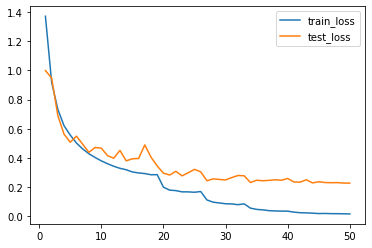

In [6]:
from math import sqrt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary


# Defining constants, based on assignment
OUTPUT_CLASSES = 10
MEANS = (0.4914, 0.4822, 0.4465)
STD_DEV = (0.2023, 0.1994, 0.2010)
IO_PROCESSES = 2
FLIP_PROBABILITY = 0.5
TRAINING_BATCH_SIZE = 32
TESTING_BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
ROOT = "./.data"
MAX_PARAMS = 5000000

# Lets start by defning transforms.
# I'm going to assume that transforms are a part of the learning process
# This implies that no transformations will be applied to the testing data
# Except the normalization step obviously
training_transformations = transforms.Compose(
    [
        transforms.RandomCrop(
            size=(32, 32), padding=4),
        transforms.RandomHorizontalFlip(
            FLIP_PROBABILITY),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STD_DEV)
    ]
)

testing_transformations = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STD_DEV)
    ]
)


def downloadData(ROOT):
    # Now we load training amd testing data
    # Note, this is different to the DataLoader step. That shall come after this
    training_data = datasets.CIFAR10(
        ROOT,
        train=True,
        download=True,
        transform=training_transformations
    )

    testing_data = datasets.CIFAR10(
        ROOT,
        train=False,
        download=True,
        transform=testing_transformations
    )

    return training_data, testing_data


if __name__ == "__main__":

    trainingData, testingData = downloadData(ROOT)

    trainingDataLoader = torch.utils.data.DataLoader(
        dataset=trainingData,
        batch_size=TRAINING_BATCH_SIZE,
        shuffle=True
    )
    testingDataLoader = torch.utils.data.DataLoader(
        dataset=testingData,
        batch_size=TESTING_BATCH_SIZE,
        shuffle=True
    )
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")

    model = ResNet18_mod().to(device)

    modelParams = model.parameters()
    setParams = {
        "params": modelParams,
        "lr": LEARNING_RATE,
        "momentum": MOMENTUM,
        "weight_decay": WEIGHT_DECAY,
        "nesterov": True,
    }

    optimizer = optim.SGD(**setParams)
    # optimizer = optim.Adam(**setParams)
    lossFunction = nn.CrossEntropyLoss()
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, LEARNING_RATE, epochs=EPOCHS,
    #                                             steps_per_epoch=len(trainingDataLoader))
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=0)

    trainingAbstraction = Basics(
        model, optimizer, sched, lossFunction, trainingDataLoader, testingDataLoader, modelName="Attempt16")

    parameters = trainingAbstraction._countParameters()
    print(f"Model has {parameters} parameters")
    assert parameters <= MAX_PARAMS
    print(f"You have {MAX_PARAMS-parameters} left!")
    summary(model, (3, 32, 32))

    trainingAbstraction.trainEpochs(EPOCHS)
